In [1]:
import random
import math

import numpy as np
from numba import njit, prange

import pandas as pd

from matplotlib import pyplot as plt

In [2]:
def gen_ring_sample(c: tuple, r1: float, r2: float, n: int):
    data = []

    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        dist = random.uniform(r1, r2)

        data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
    
    return np.array(data)


def gen_circle_smaple(c: tuple, r: float, n: int):
    data = []
    
    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        dist = random.uniform(0, r)

        data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
    
    return np.array(data)

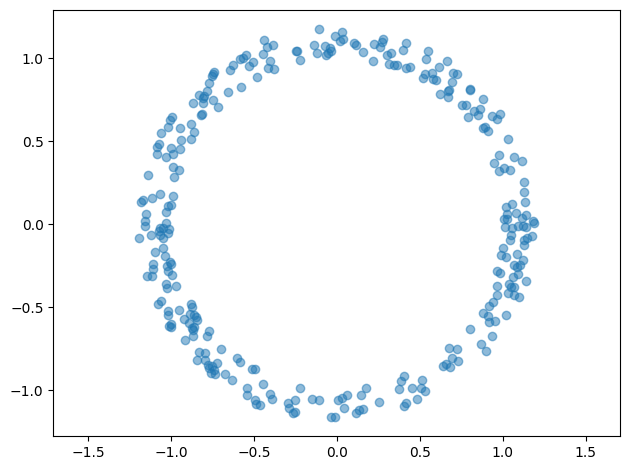

In [3]:
sample1 = gen_ring_sample((0,0), 1, 1.2, 300)

data = [sample1]

df = pd.DataFrame(columns=['x1', 'x2'])

for sample in data:
    df['x1'] = sample[:,0]
    df['x2'] = sample[:,1]

plt.scatter(df['x1'], df['x2'], alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [4]:
test_frac = 0.8

p = np.random.permutation(df.index.size)

test_size = int(p.size*test_frac)
train_size = int(p.size*(1-test_frac))

idx_test = p[0:test_size]
idx_train = p[test_size:p.size]

xTest = np.array(df.iloc[idx_test][['x1', 'x2']])

xTrain = np.array(df.iloc[idx_train][['x1', 'x2']])

In [5]:
@njit(fastmath=True)
def F(x: np.ndarray) -> np.ndarray:
    # return x
    # return np.maximum(np.zeros(x.shape), x)
    # return np.clip(x,-1, 1)
    return np.tanh(x)


@njit(fastmath=True)
def dF(x: np.ndarray) -> np.ndarray:
    # return np.ones(x.shape)
    # return 1 * (x > 0)
    # return np.array([0 if xi <= -1 or xi >= 1 else 1 for xi in x])
    return 1-np.square(np.tanh(x))


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1/(1+np.exp(-x))
    return y*(1-y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y/np.sum(y)

In [6]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, w: np.ndarray, Bh:np.ndarray, b:np.ndarray) -> tuple[np.ndarray]:
    dw = np.zeros(w.shape)
    dBh = np.zeros(Bh.shape)
    db = np.zeros(b.shape)
    
    for i in prange(xBatch.shape[0]):
        u = xBatch[i] @ w + Bh
        y = F(u) @ w.T + b

        dLdy = 2/(w.shape[0]* w.shape[1]) * (y-xBatch[i])
        
        dw += np.outer(xBatch[i], dLdy @ w) * dF(u)
        
        dBh += (dLdy @ w) * dF(u)
        db += dLdy
    
    return (dw, dBh, db)


class RestrictedBoltzmannMachine:
    def __init__(self, nIn: int, nHidden: int) -> None:
        self.nIn = nIn
        self.nHidden = nHidden
        
        self.w: np.ndarray = np.random.uniform(-1, 1, (nIn, nHidden))
        
        self.Bh: np.ndarray = np.zeros(nHidden)
        self.b: np.ndarray = np.zeros(nIn)


    def predict(self, x:np.ndarray) -> np.ndarray:
        # return (x @ self.w + self.Bh) @ self.w.T + self.b
        return F(x @ self.w + self.Bh) @ self.w.T + self.b


    def train(self, xTrain: np.ndarray, lr, batch_size, max_iter) -> None:
        n = xTrain.shape[0]

        for k in range(max_iter):
            idxs = np.random.choice(a=np.arange(n), size=batch_size, replace=False)
            
            dw, dBh, db = grads(xTrain[idxs], self.w, self.Bh, self.b)
            
            self.w -= lr*dw
            self.Bh -= lr*dBh
            self.b -= lr*db
        
    
    def loss(self, x: np.ndarray) -> float:
        xPred = np.array([self.predict(xi) for xi in x])
        d = 1/self.nIn * np.linalg.norm(x-xPred, axis=1)
        return 1/x.shape[0] * np.sum(d)

In [7]:
nIn = 2
nHidden = 8

lr = 1e-2
batch_size = 32
max_iter = 3000

model = RestrictedBoltzmannMachine(nIn, nHidden)

print('untrained loss: {0:.6f}'.format(model.loss(xTest)))

model.train(xTrain, lr, batch_size, max_iter)

print('trained loss: {0:.6f}'.format(model.loss(xTest)))

untrained loss: 0.597708
trained loss: 0.005737


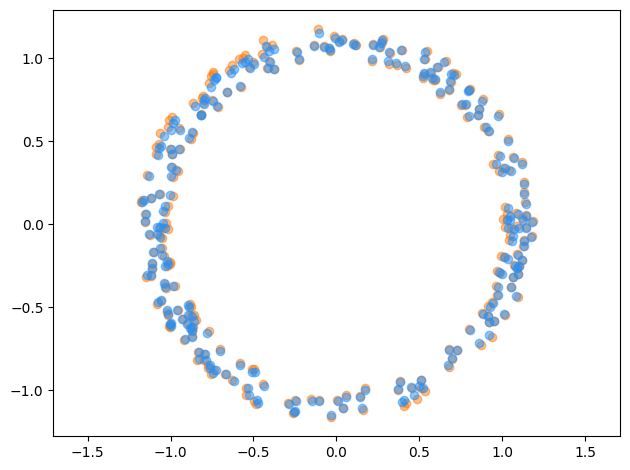

In [8]:
u = np.array([model.predict(x) for x in xTest])

plt.scatter(xTest[:,0], xTest[:,1], c='tab:orange', alpha=0.5)
plt.scatter(u[:,0], u[:,1], c='dodgerblue', alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

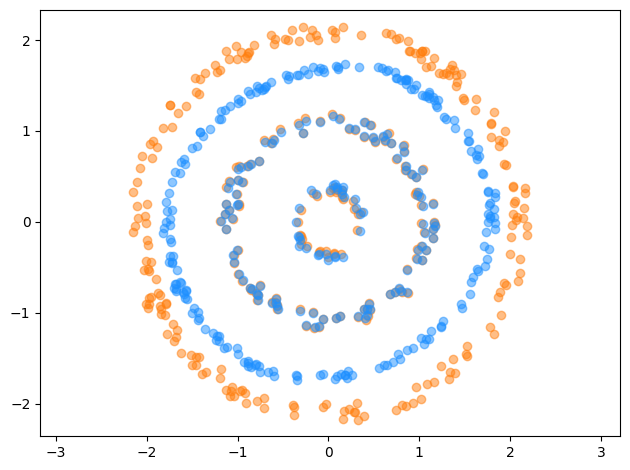

In [9]:
sample1 = gen_ring_sample((0, 0), 0.3, 0.4, 30)
sample2 = gen_ring_sample((0, 0), 1, 1.2, 100)
sample3 = gen_ring_sample((0, 0), 2, 2.2, 200)

data = [sample1, sample2, sample3]

for sample in data:
    u = np.array([model.predict(x) for x in sample])

    plt.scatter(sample[:,0], sample[:,1], c='tab:orange', alpha=0.5)
    plt.scatter(u[:,0], u[:,1], c='dodgerblue', alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()